# Определение перспективного тарифа для федерального оператора сотовой связи 

Клиентам доступно два тарифных плана: `Смарт` и `Ультра`. 

Датасет для исследования - выборка с данными 500 пользователей телеком-компании за 2018 год. В распоряжении данные об используемом тарифе, количестве сообщений, звонков и трафика для каждого пользователя.

## Задачи проекта: 
Определение наиболее выгодного тарифа для планирования стратегии маркетинговых компаний: проанализировать поведение клиентов и сделать вывод — какой тариф выбрать для продвижения.

# Описание тарифных планов

## *1 тариф `смарт`*
1. Ежемес. плата: 550 рублей
2. Что включено: 500 мин. разговора, 50 сообщений и 15 Гб веб-трафика.
3. Цена услуг сверх тарифного плана:
  - 1 минута разговора: 3 руб.
  - 1 сообщение: 3 руб.
  - 1 Гб интернет-трафика: 200 руб.
  
  
## *2 тариф `ультра`*
1. Ежемес. плата: 1950 рублей
2. Что включено: 3000 мин. разговора, 1000 сообщений и 30 Гб веб-трафика
3. Цена услуг сверх тарифного плана:
  - 1 минута разговора: 1 руб.
  - 1 сообщение: 1 руб.
  - 1 Гб интернет-трафика: 150 руб.

*Примечание:*
`Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. 
Отдельный звонок округляется отдельно: даже если он длился всего 1 секунду, то будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Но общая сумма за месяц округляется в бОльшую сторону. Если абонент использует 1025 мегабайт в конкретном месяце, с него возьмут плату за 2 гБ.`

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [45]:
# подключаю необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import copy
from scipy import stats as st
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

Далее открываю файлы, содержащие необходимые для дальнейшей работы таблицы и применяю метод info(), чтобы посмотреть общую информацию по каждой таблице, и метод head(), чтобы взглнуть на первые 5 строк таблиц.
А так же пишу функцию v_counts_columns для удобного просмотра количества уникальных значений столбцов

In [46]:
def v_counts_columns(df):
    for column in df.columns:
        print('Количесвто уникальных значения столбца', column)
        print(df[column].value_counts())

In [47]:
calls = pd.read_csv('calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [48]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [49]:
v_counts_columns(calls)

Количесвто уникальных значения столбца id
1000_0      1
1344_881    1
1344_883    1
1344_884    1
1344_885    1
           ..
1171_562    1
1171_563    1
1171_564    1
1171_565    1
1499_219    1
Name: id, Length: 202607, dtype: int64
Количесвто уникальных значения столбца call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
              ... 
2018-01-05      20
2018-01-07      18
2018-01-02       9
2018-01-03       7
2018-01-01       5
Name: call_date, Length: 365, dtype: int64
Количесвто уникальных значения столбца duration
0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
26.94        1
32.19        1
26.32        1
27.41        1
26.90        1
Name: duration, Length: 2871, dtype: int64
Количесвто уникальных значения столбца user_id
1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Len

Столбец 'duration' имеет нулевые значения. Это информации о пропущенных звонках.

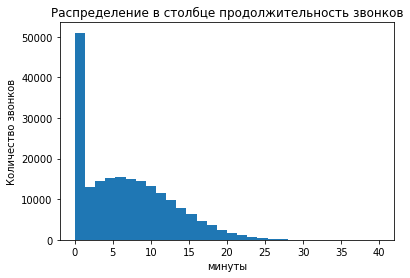

In [50]:
# Строю гистограмму, чтобы посмотреть на распределение количественной переменной в calls

plt.hist(calls['duration'], bins=30, range=(0, 40))            
plt.title('Распределение в столбце продолжительность звонков')
plt.xlabel('минуты')
plt.ylabel('Количество звонков')
plt.show()

In [51]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Ничего необычного для датасета calls не обнаружено. Звонки с продолжительностью 0 минут - пропущенные звонки.

In [52]:
internet = pd.read_csv('internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [53]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [54]:
v_counts_columns(internet)

Количесвто уникальных значения столбца Unnamed: 0
0         1
99574     1
99594     1
99595     1
99596     1
         ..
49798     1
49799     1
49800     1
49801     1
149395    1
Name: Unnamed: 0, Length: 149396, dtype: int64
Количесвто уникальных значения столбца id
1000_0      1
1333_109    1
1334_0      1
1334_1      1
1334_2      1
           ..
1172_80     1
1172_81     1
1172_82     1
1172_83     1
1499_156    1
Name: id, Length: 149396, dtype: int64
Количесвто уникальных значения столбца mb_used
0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64
Количесвто уникальных значения столбца session_date
2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
              ... 
2018-01-05      14
2018-01-04       9
2018-01-03       6
2018-01-02       3
2018-01-01       3
Name: ses

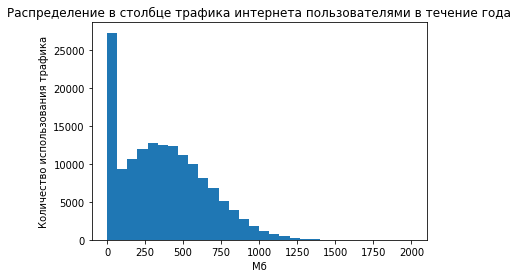

In [55]:
# Строю гистограмму, чтобы посмотреть на распределение количественной переменной в internet

plt.hist(internet['mb_used'], bins=30, range=(0, 2000))            
plt.title('Распределение в столбце трафика интернета пользователями в течение года')
plt.xlabel('Мб')
plt.ylabel('Количество использования трафика')
plt.show()

Нули в столбце 'mb_used' может быть, когда у абонента автоматом включен интернет, а он находится где-то, где сеть плохая, и удается подключиться, а передать нет. В целом, без явных аномалий.

In [56]:
#messages = pd.read_csv('messages.csv')
messages = pd.read_csv('messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [57]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [58]:
v_counts_columns(messages)

Количесвто уникальных значения столбца id
1000_0      1
1344_248    1
1344_96     1
1344_95     1
1344_94     1
           ..
1174_352    1
1174_351    1
1174_350    1
1174_349    1
1499_183    1
Name: id, Length: 123036, dtype: int64
Количесвто уникальных значения столбца message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-28    699
             ... 
2018-01-11     12
2018-01-05     10
2018-01-04     10
2018-01-02     10
2018-01-03      4
Name: message_date, Length: 364, dtype: int64
Количесвто уникальных значения столбца user_id
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64


Не выявлено аномалий в таблице message

In [59]:
tariffs = pd.read_csv('tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [60]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [61]:
v_counts_columns(tariffs)

Количесвто уникальных значения столбца messages_included
50      1
1000    1
Name: messages_included, dtype: int64
Количесвто уникальных значения столбца mb_per_month_included
15360    1
30720    1
Name: mb_per_month_included, dtype: int64
Количесвто уникальных значения столбца minutes_included
500     1
3000    1
Name: minutes_included, dtype: int64
Количесвто уникальных значения столбца rub_monthly_fee
550     1
1950    1
Name: rub_monthly_fee, dtype: int64
Количесвто уникальных значения столбца rub_per_gb
200    1
150    1
Name: rub_per_gb, dtype: int64
Количесвто уникальных значения столбца rub_per_message
3    1
1    1
Name: rub_per_message, dtype: int64
Количесвто уникальных значения столбца rub_per_minute
3    1
1    1
Name: rub_per_minute, dtype: int64
Количесвто уникальных значения столбца tariff_name
smart    1
ultra    1
Name: tariff_name, dtype: int64


Не выявлено аномалий в таблице tariffs

In [62]:
users = pd.read_csv('users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [63]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [64]:
users['churn_date'].unique()

array([nan, '2018-10-05', '2018-12-18', '2018-11-21', '2018-10-03',
       '2018-10-14', '2018-12-09', '2018-12-11', '2018-12-26',
       '2018-08-31', '2018-12-03', '2018-12-23', '2018-11-07',
       '2018-12-16', '2018-12-20', '2018-11-30', '2018-12-21',
       '2018-08-17', '2018-09-02', '2018-10-04', '2018-11-13',
       '2018-11-22', '2018-10-28', '2018-11-26', '2018-11-27',
       '2018-11-16', '2018-10-27', '2018-12-30', '2018-09-27',
       '2018-12-25', '2018-12-14', '2018-12-24', '2018-09-26',
       '2018-10-25'], dtype=object)

In [65]:
# количество пропусков
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [66]:
v_counts_columns(users)

Количесвто уникальных значения столбца user_id
1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: user_id, Length: 500, dtype: int64
Количесвто уникальных значения столбца age
53    14
42    14
63    13
64    13
71    13
73    12
21    12
40    12
37    11
29    11
39    11
26    11
47    11
70    10
45    10
41    10
52    10
58    10
36    10
66     9
23     9
50     9
65     9
19     9
48     9
24     9
68     9
27     9
28     9
51     9
20     9
56     9
30     9
60     8
44     8
69     8
62     8
55     8
74     7
25     7
46     7
35     7
32     7
67     7
43     7
31     7
18     6
75     6
54     6
59     6
72     5
22     5
34     5
33     5
38     5
49     4
57     4
61     3
Name: age, dtype: int64
Количесвто уникальных значения столбца churn_date
2018-12-03    2
2018-10-03    2
2018-10-14    2
2018-12-09    2
2018-12-21    2
2018-12-30    1
2018-10-28    1
2018-11-26    1
2018-11-27    1
2018-11-16    1
201

Таким образом, в столбце 'duration' таблицы calls есть нулевые значения. Это информации о пропущенных звонках. 
Так же есть нули в столбце 'mb_used'(объём потраченного за сессию интернет-трафика (в мегабайтах)) таблицы internet думаю, это может быть, когда у абонента автоматом включен интернет, а он находится где-то, где сеть плохая, и удается подключиться, а передать нет.
В таблице users есть 462 пропуска в столбце 'churn_date' (дата прекращения пользования тарифом), но в описаннии к данным написано, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Данные нельзя чем-то заполнить. Решаю оставить все как есть. 
Еще есть в таблице internet есть столбец 'Unnamed: 0', дублирующий индексы, видимо при заполнении или при каких-то некорректных операциях появился данный столбец. Его лучше удалить.

Потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.
В целом c данными можно работать и проверять гипотезы.

# Шаг 2. Подготовка данных

Замена типа временных данных с типа object на datetime помощью to_datetime:

In [67]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

В таблице internet есть столбец 'Unnamed: 0', дублирующий индексы. Удаляю его.

In [68]:
internet = internet.drop(labels=['Unnamed: 0'], axis=1)

В таблице calls изменение требует столбец длительности 'duration'. Для подсчета тарифа важны минуты, округленные вверх. Также поменяю тип данных на integer (целочисленный). 

In [69]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = pd.to_numeric(calls['duration'], downcast='integer')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int8          
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(1), int8(1), object(1)
memory usage: 4.8+ MB


Посмотрим по датам, сколько месяцев охватывают данные.

In [70]:
print(users['reg_date'].min(), users['reg_date'].max())
print(calls['call_date'].min(), calls['call_date'].max())
print(messages['message_date'].min(), messages['message_date'].max())
print(internet['session_date'].min(), internet['session_date'].max())

2018-01-01 00:00:00 2018-12-31 00:00:00
2018-01-01 00:00:00 2018-12-31 00:00:00
2018-01-02 00:00:00 2018-12-31 00:00:00
2018-01-01 00:00:00 2018-12-31 00:00:00


Действительно охватывается весь 2018 год. Значит рассматриваемый период - 12 месяцев.

**Расчетные значения для каждого пользователя**

Найдем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

Для начала я сделаю новые столбцы 'month' для таблиц, по которым идут расчеты

In [71]:
#Функция, для расчета месяцев
def found_month(row):
    return row.month

calls['month'] = calls['call_date'].apply(found_month)

messages['month'] = messages['message_date'].apply(found_month)

internet['month'] = internet['session_date'].apply(found_month)

internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Далее делаю сводные таблицы *по месяцам*:

In [72]:
#Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
calls_pivot = pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc=['count','sum'])
calls_pivot.columns = ['calls_count', 'all_calls_duration']
calls_pivot['all_calls_duration'] = pd.to_numeric(calls_pivot['all_calls_duration'], downcast='integer')
calls_pivot

calls_count  all_calls_duration
user_id month                                 
1000    5               22                 159
        6               43                 172
        7               47                 340
        8               52                 408
        9               58                 466
...                    ...                 ...
1498    10              41                 247
1499    9                9                  70
        10              68                 449
        11              74                 612
        12              69                 492

[3174 rows x 2 columns]

In [73]:
#Количество отправленных сообщений по месяцам для каждого пользователя
messages_pivot = pd.pivot_table(messages, index=['user_id', 'month'], values='id', aggfunc='count')
messages_pivot.columns = ['messages_count']
messages_pivot

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

In [74]:
#Объем израсходованного интернет-трафика по месяцам для каждого пользователя
internet_pivot = pd.pivot_table(internet, index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['traffic_mb']
internet_pivot['traffic_mb'] = pd.to_numeric(internet_pivot['traffic_mb'], downcast='integer')
internet_pivot

traffic_mb
user_id month            
1000    5         2253.49
        6        23233.77
        7        14003.64
        8        14055.93
        9        14568.91
...                   ...
1498    10       20579.36
1499    9         1845.75
        10       17788.51
        11       17963.31
        12       13055.58

[3203 rows x 1 columns]

In [75]:
# объединяем все три сводные таблицы в одну
dfs = [calls_pivot, messages_pivot, internet_pivot]
grouped_data = reduce((lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer')), dfs)
grouped_data.head(15)

calls_count  all_calls_duration  messages_count  traffic_mb
user_id month                                                             
1000    5             22.0               159.0            22.0     2253.49
        6             43.0               172.0            60.0    23233.77
        7             47.0               340.0            75.0    14003.64
        8             52.0               408.0            81.0    14055.93
        9             58.0               466.0            57.0    14568.91
        10            57.0               350.0            73.0    14702.49
        11            43.0               338.0            58.0    14756.47
        12            46.0               333.0            70.0     9817.61
1001    11            59.0               430.0             NaN    18429.34
        12            63.0               414.0             NaN    14036.66
1002    6             15.0               117.0             4.0    10856.82
        7             26.0               214.0            11.0    17580.10
        8             42.0               289.0            13.0    20319.26
        9             36.0               206.0             4.0    16691.08
        10            33.0               212.0            10.0    13888.25

**Теперь посчитаем *помесячную выручку* для каждого пользователя**

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [76]:
# пропущенные значения в столбцах заменяем на нули
grouped_data.loc[grouped_data['all_calls_duration'].isna(), 'all_calls_duration'] = 0
grouped_data.loc[grouped_data['messages_count'].isna(), 'messages_count'] = 0
grouped_data.loc[grouped_data['traffic_mb'].isna(), 'traffic_mb'] = 0

In [77]:
grouped_data.head()

calls_count  all_calls_duration  messages_count  traffic_mb
user_id month                                                             
1000    5             22.0               159.0            22.0     2253.49
        6             43.0               172.0            60.0    23233.77
        7             47.0               340.0            75.0    14003.64
        8             52.0               408.0            81.0    14055.93
        9             58.0               466.0            57.0    14568.91

In [78]:
# добавим наименование используемого тарифа для каждого пользователя
grouped_data = grouped_data.reset_index().merge(users[['user_id','tariff']], on="user_id").set_index(['user_id', 'month'])
grouped_data.head()

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   

              tariff  
user_id month         
1000    5      ultra  
        6      ultra  
        7      ultra  
        8      ultra  
        9      ultra

In [79]:
# Пишу функцию для подсчета чистой выручки по звонкам для каждого пользователя, сохраняю в отдельный столбец 'revenue_call'.
# Пока что не прибавляю абонентскую плату, т.к. позднее буду прибалять ее к общей прибыли по звонкам, сообщениям и интернет-трафику
def profit_calls(row):
    duration = row['all_calls_duration']
    tariff = row['tariff']
    
    if tariff == 'smart':
        extra_duration = duration - 500
        if extra_duration < 0:
            extra_duration = 0
        else:
            extra_duration *= 3
        return extra_duration
    else: 
        extra_duration = duration - 3000
        if extra_duration < 0: 
            extra_duration = 0
        else:
            extra_duration *= 1
        return extra_duration
grouped_data['revenue_call'] = grouped_data.apply(profit_calls, axis=1)
grouped_data.head(10)    

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
        10            57.0               350.0            73.0    14702.49   
        11            43.0               338.0            58.0    14756.47   
        12            46.0               333.0            70.0     9817.61   
1001    11            59.0               430.0             0.0    18429.34   
        12            63.0               414.0             0.0    14036.66   

              tariff  revenue_call  
user_id month                       
1000    5      ultra           0.0  
        6      ultra           0.0  
        7      ultra           0.0  
        8      ultra           0.0  
        9      ultra           0.0  
        10     ultra           0.0  
        11     ultra           0.0  
        12     ultra           0.0  
1001    11     smart           0.0  
        12     smart           0.0

In [80]:
# Пишу функцию для подсчета чистой выручки по сообщениям для каждого пользователя, сохраняю в отдельный столбец 'revenue_massage'.
def profit_message(row):
    duration = row['messages_count']
    tariff = row['tariff']
    
    if tariff == 'smart':
        extra_duration = duration - 50
        if extra_duration < 0:
            extra_duration = 0
        else:
            extra_duration *= 3
        return (extra_duration)
    else: 
        extra_duration = duration - 1000
        if extra_duration < 0: 
            extra_duration = 0
        else:
            extra_duration *= 1
        return (extra_duration)
grouped_data['revenue_massage'] = grouped_data.apply(profit_message, axis=1)
grouped_data.head(10)    

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
        10            57.0               350.0            73.0    14702.49   
        11            43.0               338.0            58.0    14756.47   
        12            46.0               333.0            70.0     9817.61   
1001    11            59.0               430.0             0.0    18429.34   
        12            63.0               414.0             0.0    14036.66   

              tariff  revenue_call  revenue_massage  
user_id month                                        
1000    5      ultra           0.0              0.0  
        6      ultra           0.0              0.0  
        7      ultra           0.0              0.0  
        8      ultra           0.0              0.0  
        9      ultra           0.0              0.0  
        10     ultra           0.0              0.0  
        11     ultra           0.0              0.0  
        12     ultra           0.0              0.0  
1001    11     smart           0.0              0.0  
        12     smart           0.0              0.0

In [81]:
# Перевожу Мб в Гб и округляю в большую сторону:
grouped_data['traffic_gb'] = np.ceil(grouped_data['traffic_mb'] / 1024)

In [82]:
# Пишу функцию для подсчета чистой выручки по интернет-трафику (в Гб) для каждого пользователя, сохраняю в отдельный столбец 'revenue_traffic_gb'.
def profit_traffic_gb(row):
    duration = row['traffic_gb']
    tariff = row['tariff']
    
    if tariff == 'smart':
        extra_duration = duration - 15
        if extra_duration <= 0:
            extra_duration = 0
        else:
            extra_duration *= 200
        return (extra_duration)
    else: 
        extra_duration = duration - 30
        if extra_duration <= 0: 
            extra_duration = 0
        else:
            extra_duration *= 150
        return (extra_duration)
grouped_data['revenue_traffic_gb'] = grouped_data.apply(profit_traffic_gb, axis=1)
grouped_data.head(10)

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
        10            57.0               350.0            73.0    14702.49   
        11            43.0               338.0            58.0    14756.47   
        12            46.0               333.0            70.0     9817.61   
1001    11            59.0               430.0             0.0    18429.34   
        12            63.0               414.0             0.0    14036.66   

              tariff  revenue_call  revenue_massage  traffic_gb  \
user_id month                                                     
1000    5      ultra           0.0              0.0         3.0   
        6      ultra           0.0              0.0        23.0   
        7      ultra           0.0              0.0        14.0   
        8      ultra           0.0              0.0        14.0   
        9      ultra           0.0              0.0        15.0   
        10     ultra           0.0              0.0        15.0   
        11     ultra           0.0              0.0        15.0   
        12     ultra           0.0              0.0        10.0   
1001    11     smart           0.0              0.0        18.0   
        12     smart           0.0              0.0        14.0   

               revenue_traffic_gb  
user_id month                      
1000    5                     0.0  
        6                     0.0  
        7                     0.0  
        8                     0.0  
        9                     0.0  
        10                    0.0  
        11                    0.0  
        12                    0.0  
1001    11                  600.0  
        12                    0.0

Далее создаю столбец 'final_revenue', где сложу значения чистой выручке по звонкам, сообщениям и трафику. А уже после прибавлю к этому значению абонентскую плату в соответсвии с тарифом. 

In [83]:
grouped_data['final_revenue'] = grouped_data['revenue_call'] + grouped_data['revenue_massage'] + grouped_data['revenue_traffic_gb']
grouped_data.head()

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   

              tariff  revenue_call  revenue_massage  traffic_gb  \
user_id month                                                     
1000    5      ultra           0.0              0.0         3.0   
        6      ultra           0.0              0.0        23.0   
        7      ultra           0.0              0.0        14.0   
        8      ultra           0.0              0.0        14.0   
        9      ultra           0.0              0.0        15.0   

               revenue_traffic_gb  final_revenue  
user_id month                                     
1000    5                     0.0            0.0  
        6                     0.0            0.0  
        7                     0.0            0.0  
        8                     0.0            0.0  
        9                     0.0            0.0

In [84]:
# Пишу функцию для прибавлении к финальной выручке цены за абонентскую плату в соответсвии с тарифом
def final_revenue(row):
    value = row['final_revenue'] 
    tariff = row['tariff']    
    extra_value = 0
    
    if tariff == 'smart':
        extra_value = value + 550
    else:
        extra_value = value + 1950
    return extra_value
        
grouped_data['final_revenue'] = grouped_data.apply(final_revenue, axis=1)
grouped_data.head(10) 

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
        10            57.0               350.0            73.0    14702.49   
        11            43.0               338.0            58.0    14756.47   
        12            46.0               333.0            70.0     9817.61   
1001    11            59.0               430.0             0.0    18429.34   
        12            63.0               414.0             0.0    14036.66   

              tariff  revenue_call  revenue_massage  traffic_gb  \
user_id month                                                     
1000    5      ultra           0.0              0.0         3.0   
        6      ultra           0.0              0.0        23.0   
        7      ultra           0.0              0.0        14.0   
        8      ultra           0.0              0.0        14.0   
        9      ultra           0.0              0.0        15.0   
        10     ultra           0.0              0.0        15.0   
        11     ultra           0.0              0.0        15.0   
        12     ultra           0.0              0.0        10.0   
1001    11     smart           0.0              0.0        18.0   
        12     smart           0.0              0.0        14.0   

               revenue_traffic_gb  final_revenue  
user_id month                                     
1000    5                     0.0         1950.0  
        6                     0.0         1950.0  
        7                     0.0         1950.0  
        8                     0.0         1950.0  
        9                     0.0         1950.0  
        10                    0.0         1950.0  
        11                    0.0         1950.0  
        12                    0.0         1950.0  
1001    11                  600.0         1150.0  
        12                    0.0          550.0

In [85]:
# Проверяю, превысил ли кто-то из пользователей тарифа 'ultra' лимит
grouped_data.loc[(grouped_data['final_revenue'] > 1950) & (grouped_data['tariff'] == 'ultra')].head()

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1024    11           157.0              1146.0             0.0    43107.47   
        12           136.0               949.0             0.0    35948.13   
1050    7             35.0               209.0            52.0    35177.91   
1060    12           184.0              1233.0            52.0    43931.36   
1124    10           152.0              1225.0           121.0    49745.69   

              tariff  revenue_call  revenue_massage  traffic_gb  \
user_id month                                                     
1024    11     ultra           0.0              0.0        43.0   
        12     ultra           0.0              0.0        36.0   
1050    7      ultra           0.0              0.0        35.0   
1060    12     ultra           0.0              0.0        43.0   
1124    10     ultra           0.0              0.0        49.0   

               revenue_traffic_gb  final_revenue  
user_id month                                     
1024    11                 1950.0         3900.0  
        12                  900.0         2850.0  
1050    7                   750.0         2700.0  
1060    12                 1950.0         3900.0  
1124    10                 2850.0         4800.0

In [86]:
# максимальная выручка среди пользователей тарифа 'ultra' лимит
grouped_data.loc[grouped_data['tariff'] == 'ultra']['final_revenue'].max()

4800.0

In [87]:
# максимальная выручка среди пользователей тарифа 'smart' лимит
grouped_data.loc[grouped_data['tariff'] == 'smart']['final_revenue'].max()

6770.0

In [88]:
#столбцы revenue_call, revenue_massage, revenue_traffic_gb больше не нужны. Удаляю их
grouped_data = grouped_data.drop(labels=['revenue_call', 'revenue_massage', 'revenue_traffic_gb'], axis=1)
grouped_data.head(15)

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
        10            57.0               350.0            73.0    14702.49   
        11            43.0               338.0            58.0    14756.47   
        12            46.0               333.0            70.0     9817.61   
1001    11            59.0               430.0             0.0    18429.34   
        12            63.0               414.0             0.0    14036.66   
1002    6             15.0               117.0             4.0    10856.82   
        7             26.0               214.0            11.0    17580.10   
        8             42.0               289.0            13.0    20319.26   
        9             36.0               206.0             4.0    16691.08   
        10            33.0               212.0            10.0    13888.25   

              tariff  traffic_gb  final_revenue  
user_id month                                    
1000    5      ultra         3.0         1950.0  
        6      ultra        23.0         1950.0  
        7      ultra        14.0         1950.0  
        8      ultra        14.0         1950.0  
        9      ultra        15.0         1950.0  
        10     ultra        15.0         1950.0  
        11     ultra        15.0         1950.0  
        12     ultra        10.0         1950.0  
1001    11     smart        18.0         1150.0  
        12     smart        14.0          550.0  
1002    6      smart        11.0          550.0  
        7      smart        18.0         1150.0  
        8      smart        20.0         1550.0  
        9      smart        17.0          950.0  
        10     smart        14.0          550.0

### Вывод по шагу 2:

В ходе работы над данными было сделано:

Заполнены нулевые значения в 'all_calls_duration', 'messages_count', 'traffic_mb'.
Приведены типы данных.
Сформированна таблица со всеми данными по пользователям.

# Шаг 3. Проанализирую данные

Опишу поведение клиентов оператора, исходя из выборки. 

- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаю среднее количество, дисперсию и стандартное отклонение. Построю гистограммы. Опишу распределения.

*1. Посчитаю средннее - сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?*

In [89]:
medians = grouped_data.pivot_table(index=['tariff'], values=['all_calls_duration', 'messages_count', 'traffic_mb', 'final_revenue'], aggfunc='median')
medians.head()

,all_calls_duration,final_revenue,messages_count,traffic_mb
tariff,,,,
smart,422.0,1023.0,28.0,16506.84
ultra,518.0,1950.0,38.0,19308.01


Вывод: 
- В среднем, пользователи тарифа "Смарт" не исчерпывают лимит по количеству потраченных минут звонков и по сообщениями, но превышают лимит по веб-трафику (тратят в среднем 16 Гб при включенных в пакет услуг 15 Гб). Видимо поэтому выручка в среднем с пользователей данного тарифа превышает 550 р/мес, и составляет в среднем 960 р.

- Пользователи тарифа "Ультра" в среднем не выходят за рамки включенного в пакет услуг лимита. Наоборот, почти не тратят и половины доступных минут, сообшений. В среднем тратят 19 Гб в месяц. В среднем, если мы взглянем на выручку с пользователей данного тарифа, то и тут видно, что они не выхлдят за пределы лимита, включенного в пакет услуг.

*2. Найдем среднее количество, дисперсию и стандартное отклонение:*

In [90]:
# описательная статистика:

desc_stat = grouped_data.pivot_table(index=['tariff'], values=['all_calls_duration', 'traffic_mb', 'messages_count'], 
                    aggfunc={'all_calls_duration': [np.median, np.var, np.std], 
                             'traffic_mb': [np.median, np.var, np.std], 
                             'messages_count': [np.median, np.var, np.std]})
desc_stat

all_calls_duration                            messages_count  \
                   median         std            var         median   
tariff                                                                
smart               422.0  190.313730   36219.315784           28.0   
ultra               518.0  317.606098  100873.633397           38.0   

                               traffic_mb                              
              std          var     median           std           var  
tariff                                                                 
smart   28.227876   796.812958   16506.84   5870.476681  3.446250e+07  
ultra   47.804457  2285.266143   19308.01  10087.170752  1.017510e+08

*3. Строю гистограммы, описываю распределение.*

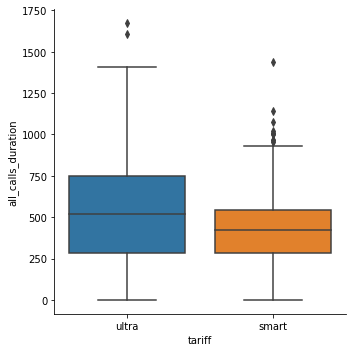

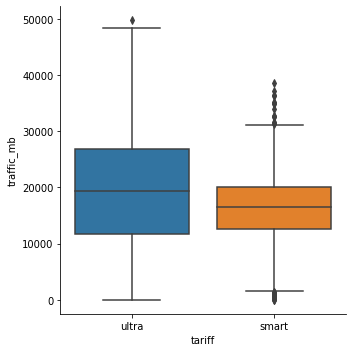

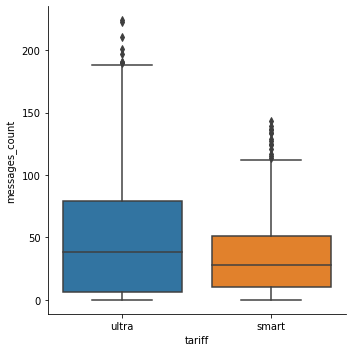

In [91]:
# смотрю выбросы по каждому тарифу, строю диаграмму размаха "ящик с усами":
for column in ['all_calls_duration', 'traffic_mb', 'messages_count']:    
    sns.catplot(x="tariff", y=column, kind="box", data=grouped_data, orient='v')

Количество потраченных минут разговора, сообщений и объема потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа "Смарт" существенно больше.

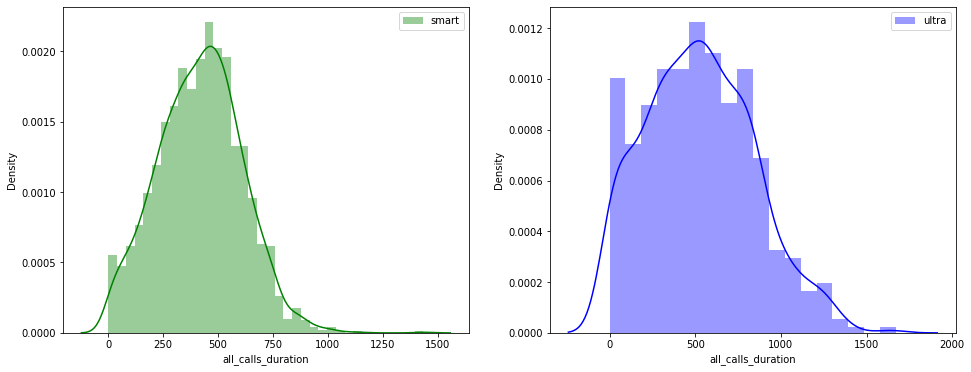

In [92]:
fig = plt.figure(figsize=(16,6))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1  = sns.distplot(grouped_data.query('tariff == "smart"')['all_calls_duration'], kde=True, label='smart', color='green')

ax_2 = fig.add_subplot(1, 2, 2)
ax_2  = sns.distplot(grouped_data.query('tariff == "ultra"')['all_calls_duration'], kde=True, label='ultra', color='blue') 

ax_1.legend(['smart'])
ax_2.legend(['ultra'])

Пользователи тарифа "Смарт" на звонки за месяц тратят от 250 до 650 минут. Примерно от 8 минут до 22 минут в день. 

Пользователи тарифа "Ультра" в осноном говорят от 230 до 900 минут. Это в разы меньше, чем предоставлено по тарифу. Нормальное распределение имеет положительную скошенность.

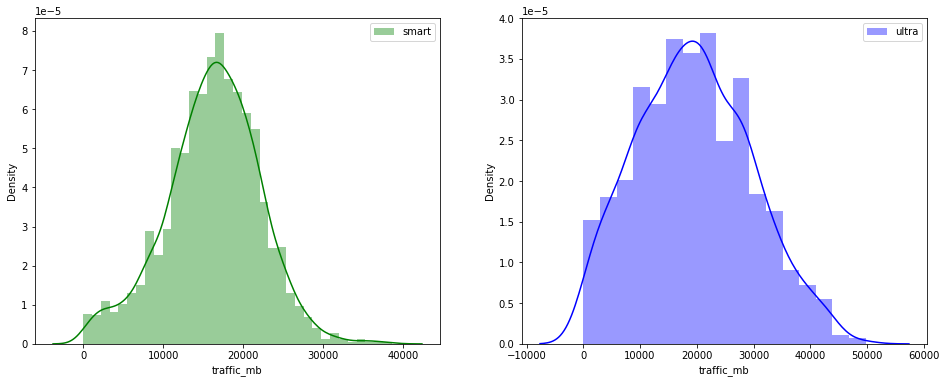

In [93]:
fig = plt.figure(figsize=(16,6))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1  = sns.distplot(grouped_data.query('tariff == "smart"')['traffic_mb'], kde=True, label='smart', color='green')

ax_2 = fig.add_subplot(1, 2, 2)
ax_2  = sns.distplot(grouped_data.query('tariff == "ultra"')['traffic_mb'], kde=True, label='ultra', color='blue') 

ax_1.legend(['smart'])
ax_2.legend(['ultra'])

Данные по пользователям тарифа "Смарт" имеют красивое нормальное распределение, симметричного типа. Пользовтели в основном тратили от 12000 до 22000 МБ. 

Пользователи тарифа "Ультра" в основном тратят от 9000 до 30000 МБ. Скошенность почти отсутсвует, нормальное распределение похоже на симметричное.

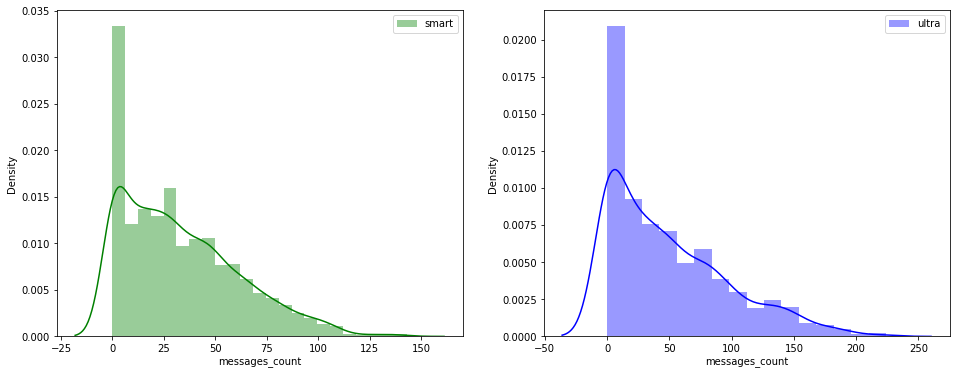

In [94]:
fig = plt.figure(figsize=(16,6))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1  = sns.distplot(grouped_data.query('tariff == "smart"')['messages_count'], kde=True, label='smart', color='green')

ax_2 = fig.add_subplot(1, 2, 2)
ax_2  = sns.distplot(grouped_data.query('tariff == "ultra"')['messages_count'], kde=True, label='ultra', color='blue') 

ax_1.legend(['smart'])
ax_2.legend(['ultra'])

Очень много пользователей тарифа "Смарт" не используют смс, используют смс до 50 штук в месяц, что является по 1-2 в день. Здесь заментна положительная скошенность нормального распределения.

Пользователи тарифа "Ульра" отправляют до 75 сообщений в месяц, что в разы меньше предложенного в тарифе. Распределение похоже на Пуассона.

### Вывод по 3 шагу:
По построенным гистограммам видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем параметрам: по длительности разговора, числу сообщений и использованному интернет-трафику. Также на гистограммах видно, что мода (наиболее часто встечаемое значение) у "Смарта" явно выражена. По длительности разговора видно, что у тарифа "Смарт" гистограмма скошена влево. По количеству потраченных сообщений тоже видно, что для обоих тарифов нормальное распределение имеет положительную скошенность.

Можно сказать, поведение пользователей тарифа "Ультра" более разнообразное. Пользователи более дорогого тарифа более свободны в выборе того, как именно и когда использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не беспокоиться о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора, кроме того мы уже выяснили, что в среднем они не тратят и половины от лимита пакета услуг.

# Шаг 4. Проверка гипотез:

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

2. средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Для оценки гипотезы будем применять тест Стюдента. 

**Проверка первой гипотезы:**

- Нулевая гипотеза H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».


- Двусторонняя альтернативная гипотеза H1  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Пороговое значение α = 5% ( .05)

In [95]:
ultra = grouped_data.query('tariff == "ultra"')['final_revenue']
smart = grouped_data.query('tariff == "smart"')['final_revenue']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False) #не равными дисперсии выборок

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


In [96]:
grouped_data.pivot_table(index=['tariff'], values=['final_revenue'], aggfunc='median')


,final_revenue
tariff,
smart,1023.0
ultra,1950.0


Cтатистический тест дал возможность опровергнуть нулевую гипотезу, и предполагать, что выручка Мегалайна с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт".
И по статистике видно, что средние значения выручки по тарифам различаются почти в 2 раза (1950/960 = 2.03). Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогу месяца заплатит гораздо больше из-за нехватки лимита в рамках тарифного пакета услуг.

**Проверка второй гипотезы:**


- H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

- H1  — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

α = 5%

In [97]:
# добавим наименование населенного пункта для каждого пользователя
grouped_data = grouped_data.reset_index().merge(users[['user_id','city']], on="user_id").set_index(['user_id', 'month'])
grouped_data

calls_count  all_calls_duration  messages_count  traffic_mb  \
user_id month                                                                
1000    5             22.0               159.0            22.0     2253.49   
        6             43.0               172.0            60.0    23233.77   
        7             47.0               340.0            75.0    14003.64   
        8             52.0               408.0            81.0    14055.93   
        9             58.0               466.0            57.0    14568.91   
...                    ...                 ...             ...         ...   
1489    8              NaN                 0.0            17.0    11050.56   
        9              NaN                 0.0            32.0    17206.30   
        10             NaN                 0.0            21.0    19559.44   
        11             NaN                 0.0            20.0    17491.56   
        12             NaN                 0.0            35.0    17322.51   

              tariff  traffic_gb  final_revenue             city  
user_id month                                                     
1000    5      ultra         3.0         1950.0        Краснодар  
        6      ultra        23.0         1950.0        Краснодар  
        7      ultra        14.0         1950.0        Краснодар  
        8      ultra        14.0         1950.0        Краснодар  
        9      ultra        15.0         1950.0        Краснодар  
...              ...         ...            ...              ...  
1489    8      smart        11.0          550.0  Санкт-Петербург  
        9      smart        17.0          950.0  Санкт-Петербург  
        10     smart        20.0         1550.0  Санкт-Петербург  
        11     smart        18.0         1150.0  Санкт-Петербург  
        12     smart        17.0          950.0  Санкт-Петербург  

[3214 rows x 8 columns]

In [98]:
# разделим данные пользователей из Москв и из регионов, проверим гипотезу

moscow = grouped_data.query('city == "Москва"')['final_revenue']
regions = grouped_data.query('city != "Москва"')['final_revenue']

alpha = .05

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Cтатистический тест не дал возможности опровергнуть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. 

In [99]:
# Найдем среднюю выручку в Мосвке:
moscow.mean()

1546.7135842880523

In [100]:
# Найдем среднюю выручку по регионам:
regions.mean()

1524.9362274298885

Действительно, средние доходы от пользователей из Москвы и из других регионов мало отличаются. 

посчитала средние

### Вывод по шагу 4
Были выдвинуты две гипотезы:

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


- Гипотеза 1 подтвердилась и говорит нам о том, что выручка по тарифамм отличается, но не известно в большую или меньшу сторону. По средней выручке можно предположить, что выручка по тарифу Ultra до 2 раз больше, чем от Smart.


- Гипотеза 2 была опровергнута. Вероятность подтверждения гипотезы около 52%, гипотезу отвергнуть не удалось. Действительно - "средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов".

# Шаг 5. Общий вывод.

В ходе моей работы было выполнено:

Просмотрена каждая таблица и выявлены аномалии.
Составлена общая таблица данных о пользователях.
Заполнены пропуски и сменены типы данных для столцов.
Добавлены необходимые столбцы для гипотез.
Проведен сравнительный анализ пользователей двух тарифов.
Проверены гипотезы на возможное соотвествие.


По результатам статистического анализа данных доходы от пользователей тарифа «Ультра» больше, чем от пользователей тарифа «Смарт». В среднем, компания получает 1950 рублей и 960 рублей от одного пользователя в месяц соответственно.

*Общая тенденция использования тарифов пользователями следующяя:*

- Пользователи тарифа «Смарт» чаще всего превышают лимит включенных услуг в рамках тарифного пакета: кроме абонентской платы 550 рублей, пользователи в среднем доплачивают еще 410 рублей ежемесячно.


- Пользователи тарифа «Ультра» в среднем, напротив, и на половину не используют тарифный пакет.


Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,525): 1546 рублей в Москве против 1524 рублей в регионах.

Фактически абоненты обоих тарифов тратят похожее количествово минут, соизмеримы и траты по трафику и смс, хотя абоненты "Ультра" тратят в среднем немного больше, но при этом, абоненты тарифа "Смарт" платят гораздо больше средств, ввиду того, что они чаще превышают лимит и платят, в соответствии с условиями тарифа, в разы больше (звонки и смс обходятся в три раза дороже). Для сотового оператора абоненты "Смарта" становятся более выгодными клиентами, в их пользу необходимо корректировать рекламный бюджет.